# Knowledge Graph Completion using DistMult

This notebook implements link prediction on a family relationship knowledge graph using the DistMult embedding method.

**Tasks:**
1. Load and preprocess the knowledge graph data
2. Implement DistMult model
3. Train the model with negative sampling
4. Evaluate using MRR, Hits@1, and Hits@10
5. Visualize training progress

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load and Preprocess Data

In [2]:
def load_triples(file_path):
    """
    Load triples from file.
    Expected format: head\trelation\ttail or head relation tail
    """
    triples = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Try tab-separated first, then space-separated
            parts = line.split('\t') if '\t' in line else line.split()
            if len(parts) == 3:
                head, relation, tail = parts
                triples.append((head.strip(), relation.strip(), tail.strip()))
    return triples

# Load train and test data
train_triples = load_triples('train.txt')
test_triples = load_triples('test.txt')

print(f"Loaded {len(train_triples)} training triples")
print(f"Loaded {len(test_triples)} test triples")
print(f"\nExample training triples:")
for i in range(min(5, len(train_triples))):
    print(f"  {train_triples[i]}")

Loaded 13821 training triples
Loaded 590 test triples

Example training triples:
  ('olivia0', 'sisterOf', 'selina10')
  ('olivia0', 'sisterOf', 'isabella11')
  ('olivia0', 'sisterOf', 'oskar24')
  ('olivia0', 'sisterOf', 'adam9')
  ('olivia0', 'secondAuntOf', 'lena18')


In [3]:
def create_mappings(train_triples, test_triples):
    """
    Create mappings from entities/relations to IDs.
    """
    entities = set()
    relations = set()
    
    # Collect all entities and relations
    for h, r, t in train_triples + test_triples:
        entities.add(h)
        entities.add(t)
        relations.add(r)
    
    # Create ID mappings
    entity2id = {entity: idx for idx, entity in enumerate(sorted(entities))}
    relation2id = {relation: idx for idx, relation in enumerate(sorted(relations))}
    
    id2entity = {idx: entity for entity, idx in entity2id.items()}
    id2relation = {idx: relation for relation, idx in relation2id.items()}
    
    return entity2id, relation2id, id2entity, id2relation

entity2id, relation2id, id2entity, id2relation = create_mappings(train_triples, test_triples)

print(f"\nNumber of entities: {len(entity2id)}")
print(f"Number of relations: {len(relation2id)}")
print(f"\nRelation types: {list(relation2id.keys())}")


Number of entities: 1316
Number of relations: 28

Relation types: ['auntOf', 'boyCousinOf', 'boyFirstCousinOnceRemovedOf', 'boySecondCousinOf', 'brotherOf', 'daughterOf', 'fatherOf', 'girlCousinOf', 'girlFirstCousinOnceRemovedOf', 'girlSecondCousinOf', 'granddaughterOf', 'grandfatherOf', 'grandmotherOf', 'grandsonOf', 'greatAuntOf', 'greatGranddaughterOf', 'greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatUncleOf', 'motherOf', 'nephewOf', 'nieceOf', 'secondAuntOf', 'secondUncleOf', 'sisterOf', 'sonOf', 'uncleOf']


In [4]:
def triples_to_ids(triples, entity2id, relation2id):
    """
    Convert string triples to ID triples.
    """
    id_triples = []
    for h, r, t in triples:
        id_triples.append((
            entity2id[h],
            relation2id[r],
            entity2id[t]
        ))
    return np.array(id_triples)

train_data = triples_to_ids(train_triples, entity2id, relation2id)
test_data = triples_to_ids(test_triples, entity2id, relation2id)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (13821, 3)
Test data shape: (590, 3)


## 3. Create Dataset with Negative Sampling

In [5]:
class KGDataset(Dataset):
    """
    Knowledge Graph Dataset with negative sampling.
    """
    def __init__(self, triples, num_entities, num_neg_samples=1):
        self.triples = triples
        self.num_entities = num_entities
        self.num_neg_samples = num_neg_samples
        
        # Create set of all true triples for filtering
        self.true_triples = set([tuple(triple) for triple in triples])
        
    def __len__(self):
        return len(self.triples)
    
    def __getitem__(self, idx):
        positive_triple = self.triples[idx]
        head, relation, tail = positive_triple
        
        # Generate negative samples by corrupting tail only
        neg_tails = []
        for _ in range(self.num_neg_samples):
            neg_tail = random.randint(0, self.num_entities - 1)
            neg_triple = (head, relation, neg_tail)
            
            # Ensure it's not a true triple
            attempts = 0
            while neg_triple in self.true_triples and attempts < 10:
                neg_tail = random.randint(0, self.num_entities - 1)
                neg_triple = (head, relation, neg_tail)
                attempts += 1
            
            neg_tails.append(neg_tail)
        
        return (
            torch.LongTensor([head]),
            torch.LongTensor([relation]),
            torch.LongTensor([tail]),
            torch.LongTensor(neg_tails)
        )

# Create dataset and dataloader
train_dataset = KGDataset(train_data, len(entity2id), num_neg_samples=10)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print(f"Created dataset with {len(train_dataset)} samples")
print(f"Batch size: 128, Number of batches: {len(train_loader)}")

Created dataset with 13821 samples
Batch size: 128, Number of batches: 108


## 4. Implement DistMult Model

In [6]:
class DistMult(nn.Module):
    """
    DistMult: Embedding Entities with Bilinear Model
    
    Score function: score(h, r, t) = <h, r, t> = sum(h * r * t)
    where h, r, t are embedding vectors
    """
    def __init__(self, num_entities, num_relations, embedding_dim=100):
        super(DistMult, self).__init__()
        
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        
        # Entity embeddings
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        
        # Relation embeddings
        self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.entity_embeddings.weight)
        nn.init.xavier_uniform_(self.relation_embeddings.weight)
    
    def forward(self, heads, relations, tails):
        """
        Compute scores for given triples.
        
        Args:
            heads: (batch_size,) or (batch_size, num_samples)
            relations: (batch_size,) or (batch_size, 1)
            tails: (batch_size,) or (batch_size, num_samples)
        
        Returns:
            scores: (batch_size,) or (batch_size, num_samples)
        """
        # Get embeddings
        h_emb = self.entity_embeddings(heads)  # (batch, dim) or (batch, num_samples, dim)
        r_emb = self.relation_embeddings(relations)  # (batch, dim)
        t_emb = self.entity_embeddings(tails)  # (batch, dim) or (batch, num_samples, dim)
        
        # Expand relation embeddings if needed
        if len(h_emb.shape) == 3:  # (batch, num_samples, dim)
            r_emb = r_emb.unsqueeze(1)  # (batch, 1, dim)
        
        # DistMult score: element-wise multiplication then sum
        scores = torch.sum(h_emb * r_emb * t_emb, dim=-1)
        
        return scores
    
    def score_all_tails(self, heads, relations):
        """
        Score all possible tails for given (head, relation) pairs.
        Used for evaluation.
        
        Args:
            heads: (batch_size,)
            relations: (batch_size,)
        
        Returns:
            scores: (batch_size, num_entities)
        """
        h_emb = self.entity_embeddings(heads)  # (batch, dim)
        r_emb = self.relation_embeddings(relations)  # (batch, dim)
        all_t_emb = self.entity_embeddings.weight  # (num_entities, dim)
        
        # Compute scores for all tails
        hr = h_emb * r_emb
        scores = torch.mm(hr, all_t_emb.t())
        
        return scores
    
    def score_all_heads(self, relations, tails):
        """
        Score all possible heads for given (relation, tail) pairs.
        Used for evaluation.
        
        Args:
            relations: (batch_size,)
            tails: (batch_size,)
        
        Returns:
            scores: (batch_size, num_entities)
        """
        r_emb = self.relation_embeddings(relations)  # (batch, dim)
        t_emb = self.entity_embeddings(tails)  # (batch, dim)
        all_h_emb = self.entity_embeddings.weight  # (num_entities, dim)
        
        # Compute scores for all heads
        rt = r_emb * t_emb
        scores = torch.mm(rt, all_h_emb.t())
        
        return scores

# Initialize model
model = DistMult(
    num_entities=len(entity2id),
    num_relations=len(relation2id),
    embedding_dim=100
).to(device)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(model)

Model initialized with 134400 parameters
DistMult(
  (entity_embeddings): Embedding(1316, 100)
  (relation_embeddings): Embedding(28, 100)
)


## 5. Define Loss Function and Optimizer

In [7]:
def margin_loss(positive_scores, negative_scores, margin=1.0):
    """
    Margin-based ranking loss.
    L = max(0, margin - positive_score + negative_score)
    """
    # positive_scores: (batch_size,)
    # negative_scores: (batch_size, num_neg_samples)
    
    # Unsqueeze positive scores to (batch_size, 1) for broadcasting
    positive_scores = positive_scores.unsqueeze(-1)  # (batch_size, 1)
    
    # Now we can broadcast: (batch_size, 1) with (batch_size, num_neg_samples)
    loss = torch.relu(margin - positive_scores + negative_scores)
    return loss.mean()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Using margin ranking loss with margin=1.0")
print(f"Optimizer: Adam with learning rate 0.001")

Using margin ranking loss with margin=1.0
Optimizer: Adam with learning rate 0.001


## 6. Training Loop

In [8]:
def train_epoch(model, train_loader, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    total_loss = 0
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        heads, relations, tails, neg_tails = batch
        
        # Move to device and squeeze
        heads = heads.squeeze().to(device)  # Remove all dimensions of size 1
        relations = relations.squeeze().to(device)
        tails = tails.squeeze().to(device)
        neg_tails = neg_tails.to(device)
        
        # Ensure proper shapes
        if heads.dim() == 0:  # Single sample edge case
            heads = heads.unsqueeze(0)
            relations = relations.unsqueeze(0)
            tails = tails.unsqueeze(0)
            neg_tails = neg_tails.unsqueeze(0)
        
        optimizer.zero_grad()
        
        # Compute positive scores
        positive_scores = model(heads, relations, tails)  # Should be (batch_size,)
        
        # Debug first batch
        if batch_idx == 0:
            print(f"Debug - heads shape: {heads.shape}")
            print(f"Debug - relations shape: {relations.shape}")
            print(f"Debug - tails shape: {tails.shape}")
            print(f"Debug - neg_tails shape: {neg_tails.shape}")
            print(f"Debug - positive_scores shape: {positive_scores.shape}")
        
        # Expand heads and relations for negative samples
        batch_size = heads.size(0)
        num_neg = neg_tails.size(1) if neg_tails.dim() > 1 else 1
        
        if neg_tails.dim() == 1:  # Edge case
            neg_tails = neg_tails.unsqueeze(0)
        
        heads_expanded = heads.unsqueeze(1).expand(batch_size, num_neg)
        relations_expanded = relations.unsqueeze(1).expand(batch_size, num_neg)
        
        # Compute negative scores
        negative_scores = model(heads_expanded, relations_expanded, neg_tails)
        
        if batch_idx == 0:
            print(f"Debug - heads_expanded shape: {heads_expanded.shape}")
            print(f"Debug - relations_expanded shape: {relations_expanded.shape}")
            print(f"Debug - negative_scores shape: {negative_scores.shape}")
        
        # Compute loss
        loss = margin_loss(positive_scores, negative_scores, margin=1.0)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Train the model
num_epochs = 100
train_losses = []

print(f"\nStarting training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    loss = train_epoch(model, train_loader, optimizer, device)
    train_losses.append(loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

print("\nTraining completed!")


Starting training for 100 epochs...



Training:   1%|          | 1/108 [00:00<00:14,  7.27it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 15.47it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.96it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 12.69it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.77it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.57it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.21it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.12it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 17.93it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.50it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 10/100, Loss: 0.0039


Training:   2%|▏         | 2/108 [00:00<00:06, 16.53it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   4%|▎         | 4/108 [00:00<00:05, 19.13it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 14.54it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.94it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.09it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 14.84it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.96it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   4%|▎         | 4/108 [00:00<00:05, 19.35it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.82it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.04it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 20/100, Loss: 0.0020


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 19.27it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 19.17it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.52it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.08it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 15.83it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 15.59it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.72it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.52it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:11,  9.00it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 30/100, Loss: 0.0016


Training:   2%|▏         | 2/108 [00:00<00:07, 14.74it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 13.07it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 13.04it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 11.91it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.12it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 13.26it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.56it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 19.35it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.56it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.44it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 40/100, Loss: 0.0014


Training:   2%|▏         | 2/108 [00:00<00:06, 16.64it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.14it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.85it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.39it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 15.92it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.48it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   4%|▎         | 4/108 [00:00<00:05, 19.78it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.63it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 13.90it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 14.24it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 50/100, Loss: 0.0011


Training:   2%|▏         | 2/108 [00:00<00:07, 13.70it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 17.83it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.12it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.32it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.55it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 14.95it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.17it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 17.13it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.48it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.15it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 60/100, Loss: 0.0009


Training:   1%|          | 1/108 [00:00<00:11,  9.66it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   1%|          | 1/108 [00:00<00:11,  9.25it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.53it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   4%|▎         | 4/108 [00:00<00:05, 19.65it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 19.75it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.63it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 12.80it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 13.51it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.44it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:07, 14.53it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 70/100, Loss: 0.0008


Training:   2%|▏         | 2/108 [00:00<00:06, 15.53it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.87it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.19it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.58it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.99it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.39it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.44it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 19.18it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   4%|▎         | 4/108 [00:00<00:05, 19.23it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.60it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 80/100, Loss: 0.0008


Training:   2%|▏         | 2/108 [00:00<00:08, 12.91it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.33it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 12.21it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.29it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:08, 13.12it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.05it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.66it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.31it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.72it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   1%|          | 1/108 [00:00<00:11,  9.32it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 90/100, Loss: 0.0007


Training:   2%|▏         | 2/108 [00:00<00:06, 16.90it/s]

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.11it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.19it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.07it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.52it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.33it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   1%|          | 1/108 [00:00<00:12,  8.64it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.71it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:06, 16.01it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Training:   2%|▏         | 2/108 [00:00<00:05, 18.71it/s]  

Debug - heads shape: torch.Size([128])
Debug - relations shape: torch.Size([128])
Debug - tails shape: torch.Size([128])
Debug - neg_tails shape: torch.Size([128, 10])
Debug - positive_scores shape: torch.Size([128])
Debug - heads_expanded shape: torch.Size([128, 10])
Debug - relations_expanded shape: torch.Size([128, 10])
Debug - negative_scores shape: torch.Size([128, 128, 10])


Epoch 100/100, Loss: 0.0006

Training completed!


## 7. Plot Training Loss

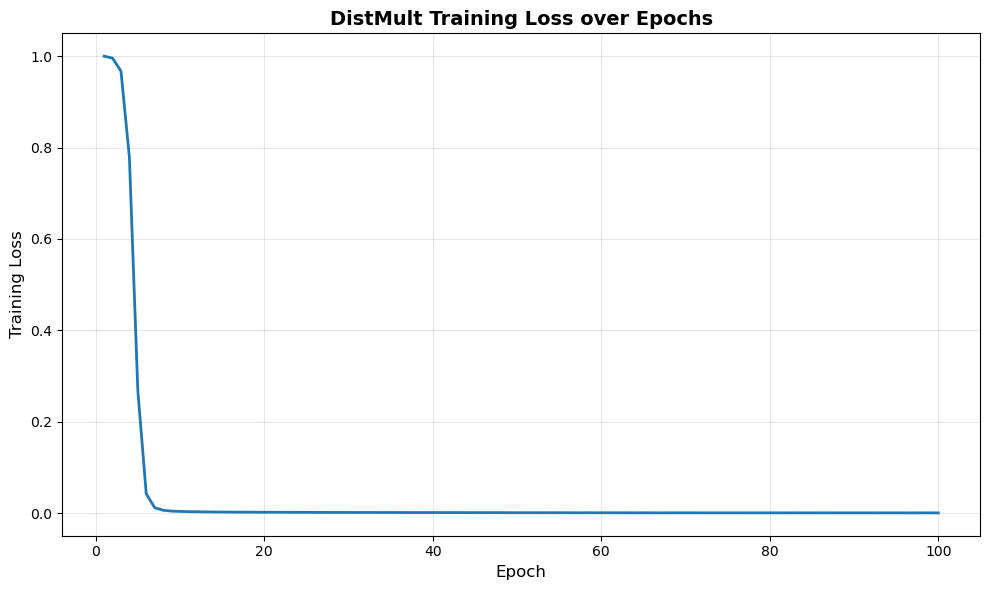

Final training loss: 0.0006
Plot saved as 'training_loss.png'


In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('DistMult Training Loss over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Plot saved as 'training_loss.png'")

## 8. Evaluation Functions

In [10]:
def get_filtered_rank(model, test_triple, all_triples, num_entities, device, mode='tail'):
    """
    Get filtered rank for a test triple.
    
    Args:
        test_triple: (head, relation, tail) as IDs
        all_triples: set of all known triples (train + test)
        mode: 'tail' or 'head' prediction
    
    Returns:
        rank: filtered rank of the true entity
    """
    head, relation, tail = test_triple
    
    if mode == 'tail':
        # Predict tail given (head, relation)
        heads_tensor = torch.LongTensor([head]).to(device)
        relations_tensor = torch.LongTensor([relation]).to(device)
        
        with torch.no_grad():
            scores = model.score_all_tails(heads_tensor, relations_tensor).squeeze()
        
        # Filter out other true triples
        for i in range(num_entities):
            if i != tail and (head, relation, i) in all_triples:
                scores[i] = -1e10  # Set to very low score
        
        # Get rank of true tail
        sorted_indices = torch.argsort(scores, descending=True)
        rank = (sorted_indices == tail).nonzero(as_tuple=True)[0].item() + 1
        
    else:  # mode == 'head'
        # Predict head given (relation, tail)
        relations_tensor = torch.LongTensor([relation]).to(device)
        tails_tensor = torch.LongTensor([tail]).to(device)
        
        with torch.no_grad():
            scores = model.score_all_heads(relations_tensor, tails_tensor).squeeze()
        
        # Filter out other true triples
        for i in range(num_entities):
            if i != head and (i, relation, tail) in all_triples:
                scores[i] = -1e10
        
        # Get rank of true head
        sorted_indices = torch.argsort(scores, descending=True)
        rank = (sorted_indices == head).nonzero(as_tuple=True)[0].item() + 1
    
    return rank

def evaluate(model, test_data, all_triples, num_entities, device):
    """
    Evaluate model on test data.
    
    Returns:
        Dictionary with MRR, Hits@1, Hits@3, Hits@10
    """
    model.eval()
    
    ranks_tail = []
    ranks_head = []
    
    print("Evaluating on test set...")
    
    for triple in tqdm(test_data, desc="Evaluating"):
        # Tail prediction
        rank_tail = get_filtered_rank(model, triple, all_triples, num_entities, device, mode='tail')
        ranks_tail.append(rank_tail)
        
        # Head prediction
        rank_head = get_filtered_rank(model, triple, all_triples, num_entities, device, mode='head')
        ranks_head.append(rank_head)
    
    # Combine ranks from both directions
    all_ranks = ranks_tail + ranks_head
    
    # Calculate metrics
    mrr = np.mean([1.0 / rank for rank in all_ranks])
    hits_at_1 = np.mean([1.0 if rank <= 1 else 0.0 for rank in all_ranks])
    hits_at_3 = np.mean([1.0 if rank <= 3 else 0.0 for rank in all_ranks])
    hits_at_10 = np.mean([1.0 if rank <= 10 else 0.0 for rank in all_ranks])
    
    results = {
        'MRR': mrr,
        'Hits@1': hits_at_1,
        'Hits@3': hits_at_3,
        'Hits@10': hits_at_10,
        'ranks_tail': ranks_tail,
        'ranks_head': ranks_head
    }
    
    return results

print("Evaluation functions defined.")

Evaluation functions defined.


## 9. Run Evaluation on Test Set

In [11]:
# Create set of all triples (train + test) for filtering
all_triples = set([tuple(triple) for triple in train_data] + [tuple(triple) for triple in test_data])

# Evaluate
results = evaluate(model, test_data, all_triples, len(entity2id), device)

print("\n" + "="*50)
print("EVALUATION RESULTS ON TEST SET")
print("="*50)
print(f"MRR:      {results['MRR']:.4f}")
print(f"Hits@1:   {results['Hits@1']:.4f}")
print(f"Hits@3:   {results['Hits@3']:.4f}")
print(f"Hits@10:  {results['Hits@10']:.4f}")
print("="*50)

Evaluating on test set...


Evaluating: 100%|██████████| 590/590 [00:00<00:00, 961.22it/s] 


EVALUATION RESULTS ON TEST SET
MRR:      0.6677
Hits@1:   0.4941
Hits@3:   0.8161
Hits@10:  0.9508


## 10. Visualize Evaluation Metrics

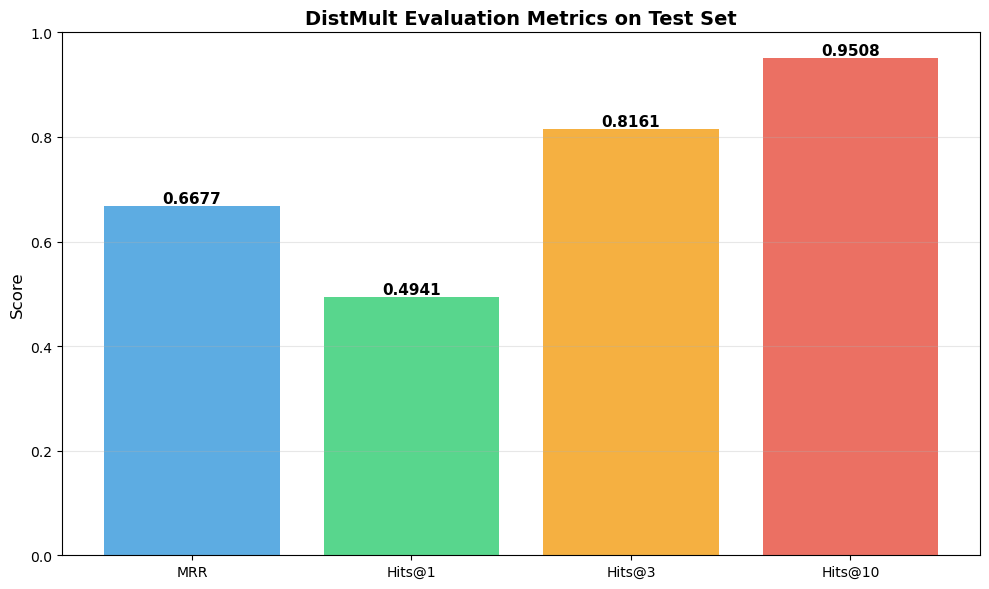

Plot saved as 'evaluation_metrics.png'


In [12]:
# Bar plot of metrics
metrics = ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']
values = [results['MRR'], results['Hits@1'], results['Hits@3'], results['Hits@10']]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'], alpha=0.8)
plt.ylabel('Score', fontsize=12)
plt.title('DistMult Evaluation Metrics on Test Set', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'evaluation_metrics.png'")

## 11. Analyze Rank Distribution

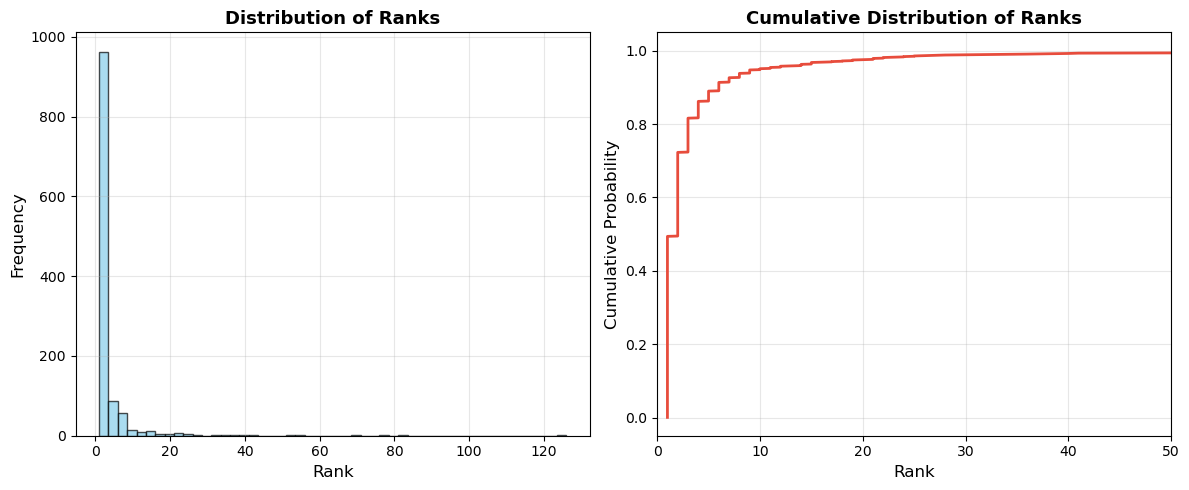

Mean rank: 3.33
Median rank: 2
Plot saved as 'rank_distribution.png'


In [13]:
# Plot rank distribution
all_ranks = results['ranks_tail'] + results['ranks_head']

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(all_ranks, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Ranks', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

# CDF
plt.subplot(1, 2, 2)
sorted_ranks = np.sort(all_ranks)
cdf = np.arange(1, len(sorted_ranks) + 1) / len(sorted_ranks)
plt.plot(sorted_ranks, cdf, linewidth=2, color='#e74c3c')
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Cumulative Distribution of Ranks', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(0, 50)

plt.tight_layout()
plt.savefig('rank_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Mean rank: {np.mean(all_ranks):.2f}")
print(f"Median rank: {np.median(all_ranks):.0f}")
print(f"Plot saved as 'rank_distribution.png'")

## 12. Example Predictions

In [14]:
def predict_tail(model, head_name, relation_name, entity2id, relation2id, id2entity, top_k=5):
    """
    Predict top-k tails for a given (head, relation) pair.
    """
    head_id = entity2id[head_name]
    relation_id = relation2id[relation_name]
    
    heads_tensor = torch.LongTensor([head_id]).to(device)
    relations_tensor = torch.LongTensor([relation_id]).to(device)
    
    model.eval()
    with torch.no_grad():
        scores = model.score_all_tails(heads_tensor, relations_tensor).squeeze()
    
    # Get top-k predictions
    top_scores, top_indices = torch.topk(scores, k=top_k)
    
    predictions = []
    for score, idx in zip(top_scores, top_indices):
        tail_name = id2entity[idx.item()]
        predictions.append((tail_name, score.item()))
    
    return predictions

# Show some example predictions
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)

# Get a few test triples for demonstration
num_examples = min(3, len(test_triples))
for i in range(num_examples):
    h, r, t = test_triples[i]
    print(f"\nQuery: ({h}, {r}, ?)")
    print(f"True answer: {t}")
    print(f"\nTop-5 predictions:")
    
    predictions = predict_tail(model, h, r, entity2id, relation2id, id2entity, top_k=5)
    for rank, (pred_tail, score) in enumerate(predictions, 1):
        marker = "✓" if pred_tail == t else " "
        print(f"  {rank}. {pred_tail:20s} (score: {score:7.4f}) {marker}")
    print("-" * 50)


EXAMPLE PREDICTIONS

Query: (olivia0, motherOf, ?)
True answer: nico4

Top-5 predictions:
  1. elias6               (score:  3.3001)  
  2. lisa5                (score:  3.1147)  
  3. katharina1           (score:  2.8622)  
  4. nico4                (score:  2.4803) ✓
  5. lena18               (score:  1.9642)  
--------------------------------------------------

Query: (katharina1, motherOf, ?)
True answer: olivia0

Top-5 predictions:
  1. isabella11           (score:  3.4810)  
  2. oskar24              (score:  3.4240)  
  3. selina10             (score:  3.3719)  
  4. adam9                (score:  3.3287)  
  5. olivia0              (score:  2.8622) ✓
--------------------------------------------------

Query: (emma7, motherOf, ?)
True answer: katharina1

Top-5 predictions:
  1. paula12              (score:  3.2610)  
  2. natalie13            (score:  3.1940)  
  3. luis14               (score:  2.7165)  
  4. katharina1           (score:  2.1097) ✓
  5. julian1242           (sc

## 13. Save Model (Optional)

In [ ]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'entity2id': entity2id,
    'relation2id': relation2id,
    'id2entity': id2entity,
    'id2relation': id2relation,
    'embedding_dim': model.embedding_dim,
    'results': results
}

torch.save(checkpoint, 'distmult_model.pt')
print("Model saved as 'distmult_model.pt'")

# To load later:
# checkpoint = torch.load('distmult_model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

## 14. Summary Report

In [15]:
print("\n" + "="*70)
print(" "*20 + "FINAL SUMMARY REPORT")
print("="*70)
print(f"\nDataset Statistics:")
print(f"  - Training triples:     {len(train_triples):,}")
print(f"  - Test triples:         {len(test_triples):,}")
print(f"  - Number of entities:   {len(entity2id):,}")
print(f"  - Number of relations:  {len(relation2id):,}")
print(f"\nModel Configuration:")
print(f"  - Model:                DistMult")
print(f"  - Embedding dimension:  {model.embedding_dim}")
print(f"  - Total parameters:     {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Training epochs:      {num_epochs}")
print(f"  - Final training loss:  {train_losses[-1]:.4f}")
print(f"\nTest Set Performance (Filtered):")
print(f"  - MRR:                  {results['MRR']:.4f}")
print(f"  - Hits@1:               {results['Hits@1']:.4f}")
print(f"  - Hits@3:               {results['Hits@3']:.4f}")
print(f"  - Hits@10:              {results['Hits@10']:.4f}")
print(f"  - Mean rank:            {np.mean(all_ranks):.2f}")
print(f"  - Median rank:          {np.median(all_ranks):.0f}")
print("\n" + "="*70)
print("\nFiles saved:")
print("  - training_loss.png")
print("  - evaluation_metrics.png")
print("  - rank_distribution.png")
print("  - distmult_model.pt")
print("="*70)


                    FINAL SUMMARY REPORT

Dataset Statistics:
  - Training triples:     13,821
  - Test triples:         590
  - Number of entities:   1,316
  - Number of relations:  28

Model Configuration:
  - Model:                DistMult
  - Embedding dimension:  100
  - Total parameters:     134,400
  - Training epochs:      100
  - Final training loss:  0.0006

Test Set Performance (Filtered):
  - MRR:                  0.6677
  - Hits@1:               0.4941
  - Hits@3:               0.8161
  - Hits@10:              0.9508
  - Mean rank:            3.33
  - Median rank:          2


Files saved:
  - training_loss.png
  - evaluation_metrics.png
  - rank_distribution.png
  - distmult_model.pt
